In [19]:
# Imports
import os, cv2, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tiff

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [4]:
!unzip "/content/drive/MyDrive/Computer Vision Tasks - Cellula/week 3/data-20250919T092629Z-1-001.zip" -d "/content/"

Archive:  /content/drive/MyDrive/Computer Vision Tasks - Cellula/week 3/data-20250919T092629Z-1-001.zip
  inflating: /content/data/images/2.tif  
  inflating: /content/data/images/303.tif  
  inflating: /content/data/images/302.tif  
  inflating: /content/data/images/301.tif  
  inflating: /content/data/images/304.tif  
  inflating: /content/data/images/305.tif  
  inflating: /content/data/images/298.tif  
  inflating: /content/data/images/297.tif  
  inflating: /content/data/images/300.tif  
  inflating: /content/data/images/294.tif  
  inflating: /content/data/images/296.tif  
  inflating: /content/data/images/295.tif  
  inflating: /content/data/images/299.tif  
  inflating: /content/data/images/292.tif  
  inflating: /content/data/images/291.tif  
  inflating: /content/data/images/289.tif  
  inflating: /content/data/images/287.tif  
  inflating: /content/data/images/293.tif  
  inflating: /content/data/images/288.tif  
  inflating: /content/data/images/290.tif  
  inflating: /cont

In [21]:
# Data Setup

train_img_dir = "/content/data/images"
train_mask_dir = "/content/data/labels"

# Check file extensions
image_extensions = {f.split('.')[-1] for f in os.listdir(train_img_dir)}
mask_extensions  = {f.split('.')[-1] for f in os.listdir(train_mask_dir)}

print("Image extensions:", image_extensions)
print("Mask extensions:", mask_extensions)

Image extensions: {'tif'}
Mask extensions: {'png'}


Selected: 221.tif
Image shape: (128, 128, 12)
Mask shape: (128, 128)


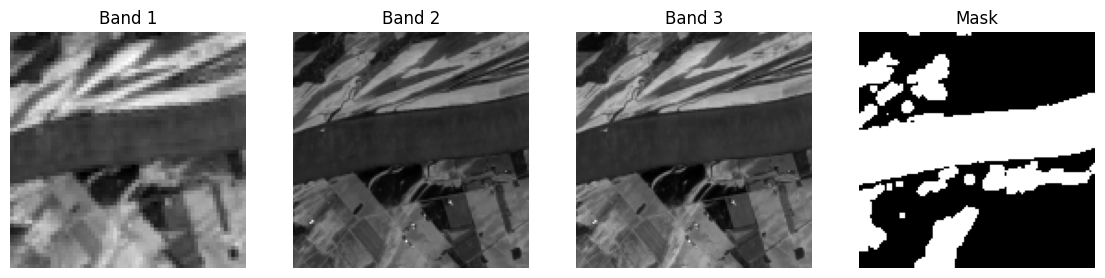

In [22]:
# Quick Visualization
def display_image_and_mask(img_path, mask_path):
    img = tiff.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)

    fig, axes = plt.subplots(1, 4, figsize=(14, 4))
    for i in range(3):
        axes[i].imshow(img[:,:,i], cmap="gray")
        axes[i].set_title(f"Band {i+1}")
        axes[i].axis("off")

    axes[3].imshow(mask, cmap="gray")
    axes[3].set_title("Mask")
    axes[3].axis("off")
    plt.show()

# Pick random example
random_name = random.choice(os.listdir(train_img_dir))
img_path = os.path.join(train_img_dir, random_name)
mask_path = os.path.join(train_mask_dir, random_name.replace(".tif", ".png"))

print("Selected:", random_name)
display_image_and_mask(img_path, mask_path)


In [27]:
# Match Images & Masks
image_files = [f.replace(".tif", "") for f in os.listdir(train_img_dir) if f.endswith(".tif")]
mask_files  = [f.replace(".png", "") for f in os.listdir(train_mask_dir) if f.endswith(".png")]

common_files = sorted(set(image_files).intersection(set(mask_files)))

print("Total images:", len(image_files))
print("Total masks:", len(mask_files))
print("Matched pairs:", len(common_files))

images = [os.path.join(train_img_dir, f + ".tif") for f in common_files]
masks  = [os.path.join(train_mask_dir, f + ".png") for f in common_files]

data = pd.DataFrame({"image": images, "mask": masks})
print(data.head())

train_df, val_df = train_test_split(data, train_size=0.8, shuffle=True, random_state=42)


Total images: 306
Total masks: 456
Matched pairs: 306
                          image                          mask
0    /content/data/images/0.tif    /content/data/labels/0.png
1    /content/data/images/1.tif    /content/data/labels/1.png
2   /content/data/images/10.tif   /content/data/labels/10.png
3  /content/data/images/100.tif  /content/data/labels/100.png
4  /content/data/images/101.tif  /content/data/labels/101.png


In [28]:
# Data Loaders
def load_image(img_path):
    img = tiff.imread(img_path).astype("float32")
    img = img / 255.0   # normalize
    return img

def load_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype("float32")
    mask = np.expand_dims(mask, axis=-1)  # (128,128,1)
    return mask

def data_generator(df, batch_size=16, augment_fn=None):
    while True:
        batch = df.sample(batch_size)
        imgs, masks = [], []
        for _, row in batch.iterrows():
            img = load_image(row["image"])
            mask = load_mask(row["mask"])

            if augment_fn:
                img, mask = augment_fn(img, mask)

            imgs.append(img)
            masks.append(mask)
        yield np.array(imgs), np.array(masks)


In [29]:
# Data Augmentation
@tf.function
def augment(img, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # Random 90 rotations
    if tf.random.uniform(()) > 0.5:
        k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        img = tf.image.rot90(img, k)
        mask = tf.image.rot90(mask, k)

    return img, mask


In [30]:
# Generators with Augmentation
train_generator = data_generator(train_df, batch_size=16, augment_fn=augment)
val_generator   = data_generator(val_df, batch_size=16, augment_fn=None)

In [31]:
# UNet Model
def unet_model(input_size=(128,128,12)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    return Model(inputs, outputs)

model = unet_model(input_size=(128,128,12))
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_df)//16,
    validation_steps=len(val_df)//16
)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 54s 914ms/step - accuracy: 0.6745 - loss: 0.5949 - val_accuracy: 0.8804 - val_loss: 0.3443
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 892ms/step - accuracy: 0.8609 - loss: 0.3709 - val_accuracy: 0.9101 - val_loss: 0.2879
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.8816 - loss: 0.3092 - val_accuracy: 0.9006 - val_loss: 0.3036
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.8792 - loss: 0.3154 - val_accuracy: 0.8987 - val_loss: 0.2800
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.8692 - loss: 0.3277 - val_accuracy: 0.9038 - val_loss: 0.2587
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8922 - loss: 0.2883 - val_accuracy: 0.9011 - val_loss: 0.2631
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.9102 - loss: 0.2529 - val_accuracy: 0.9110 - val_loss: 0.2400
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.8972 - loss: 0.2682 - val_accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


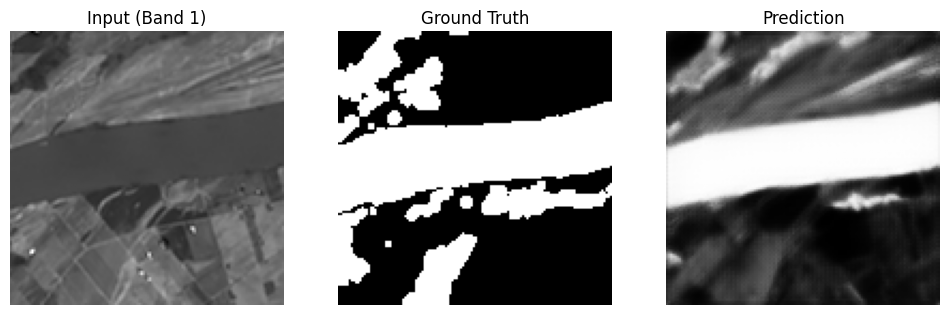

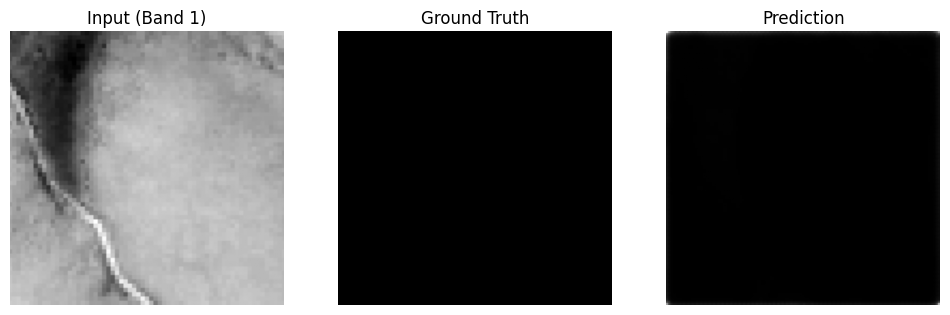

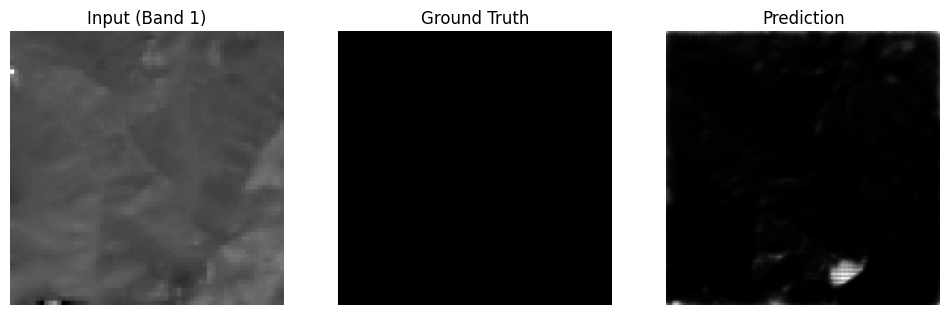

In [33]:
# Visualization of Predictions
imgs, masks = next(val_generator)
preds = model.predict(imgs)

for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(imgs[i][:,:,0], cmap="gray")
    plt.title("Input (Band 1)")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(masks[i].squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")
    plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9209 - loss: 0.1980
Validation Loss: 0.2043
Validation Accuracy: 0.9160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Mean IoU: 0.6211
Mean Dice: 0.7174


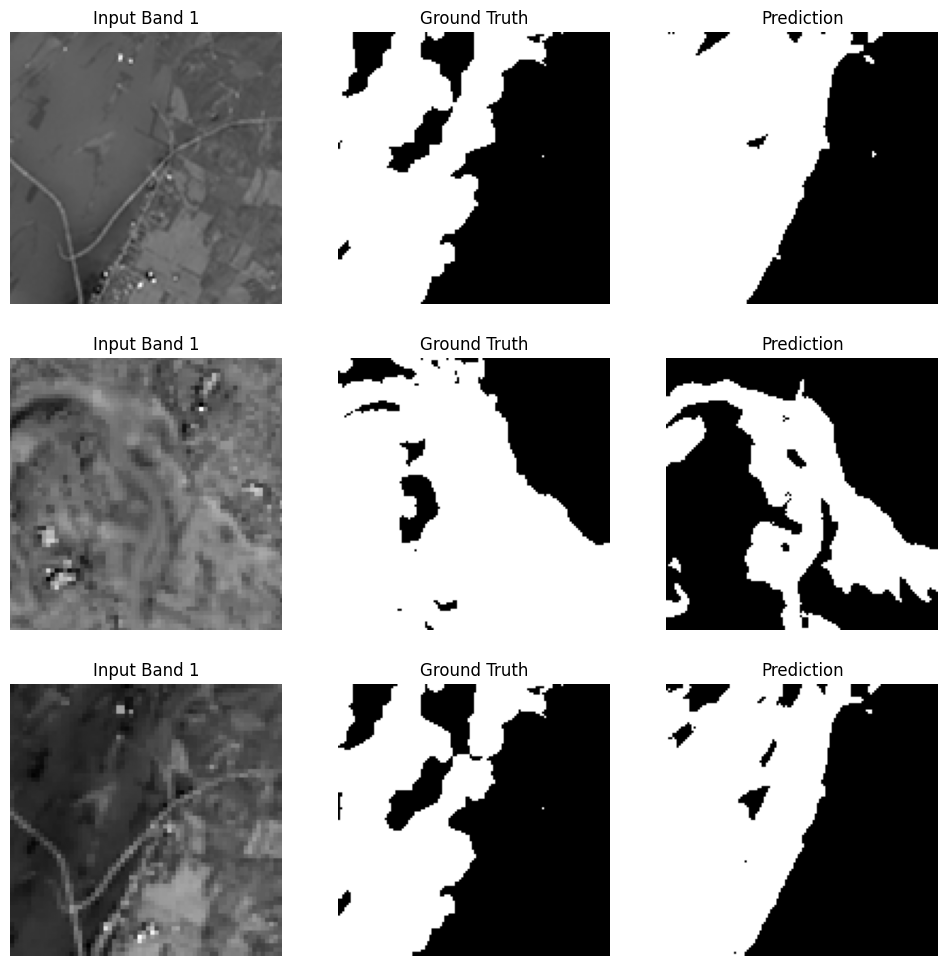

In [34]:
# Evaluation on Validation Data

# Evaluate using built-in Keras metrics
val_steps = len(val_df) // 16
loss, acc = model.evaluate(val_generator, steps=val_steps)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")


# metrics (IoU + Dice)
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred > 0.5, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection + smooth
    )

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred > 0.5, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )


# Evaluate on a full batch from val_generator
imgs, masks = next(val_generator)
preds = model.predict(imgs)

iou_scores = [iou_coef(masks[i], preds[i]).numpy() for i in range(len(imgs))]
dice_scores = [dice_coef(masks[i], preds[i]).numpy() for i in range(len(imgs))]

print(f"Mean IoU: {np.mean(iou_scores):.4f}")
print(f"Mean Dice: {np.mean(dice_scores):.4f}")


# Visualize some predictions
n = 3  # number of samples to show
plt.figure(figsize=(12, 4*n))

for i in range(n):
    plt.subplot(n, 3, 3*i+1)
    plt.imshow(imgs[i][:,:,0], cmap="gray")  # show band 1
    plt.title("Input Band 1")
    plt.axis("off")

    plt.subplot(n, 3, 3*i+2)
    plt.imshow(masks[i].squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(n, 3, 3*i+3)
    plt.imshow((preds[i].squeeze() > 0.5).astype(np.float32), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

plt.show()
